In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

sns.set()

paths = {
    'macro': 'macro_results/',
    'micro': 'micro_results/',
}

# sns.set_style('whitegrid')

In [2]:
def load_evolution_results(seed=123, database='', macro=True):
    # Load offspring results 
    if macro:
        results_path = paths['macro']
    else:
        results_path = paths['micro']
    ev_results = pd.read_csv(os.path.join(results_path, 'seed_' + str(seed),
                                          'parent_child_' + database),
                             names=['parent', 'child'])
    ev_results['index'] = ev_results.index
    ev_results = pd.melt(ev_results, id_vars=['index'])
    initial_population_scores = pd.read_csv(os.path.join(results_path,
                                                         'seed_' + str(seed),
                                                         'initial_population_' + database),
                                            header=None,
                                            names=['scores'])
    # Load timing results
    if macro:
        results_path = paths['macro']
    else:
        results_path = paths['micro']
    ev_time = open(os.path.join(results_path,
                                'seed_' + str(seed),
                                'time_' + database), 'r').read()
    # Load population stats
    population_stats = pd.read_csv(os.path.join(results_path,
                                                'seed_' + str(seed),
                                                'population_stats_' + database))
    population_stats['index'] = population_stats.index
    population_stats = pd.melt(population_stats, id_vars=['index'])
    return ev_results, ev_time, initial_population_scores, population_stats

In [3]:
def load_RL_results(seed=123, database='', macro=True):
    indexes = []
    val_scores = []
    store = False
    times = []
    if macro:
        results_path = paths['macro']
    else:
        results_path = paths['micro']
    with open(os.path.join(results_path, 'seed_' + str(seed), 'results_RL_' + database), 'r') as fp:
        for index, line in enumerate(fp):
            if 'took' in line:
#                 print(line.split())
                times.append(float(line.split()[-1]))
            if 'val_score' in line and store:
                val_scores.append(float(line.split(',')[0].split(':')[1]))
            if 'training controller' in line:
                indexes.append(index)
                if 'over' in line:
                    store = False
                else:
                    store = True
    df = pd.DataFrame()
#     print('val_scores len: ', len(val_scores))
    df['index'] = np.arange(len(val_scores))
    df['val_scores'] = np.array(val_scores)
    return df, pd.DataFrame(np.array(times), columns=['times'])

In [4]:
def draw_lineplots(database, ev_results, rl_results, all_seeds=False, macro=True):
    # parent_child_acc
    fig, ax = plt.subplots(1, 2, figsize=(18.75, 6), sharey=True)

    sns.lineplot(x='index', y='value', hue='variable', data=ev_results, ax=ax[0])
    sns.lineplot(x='index', y='val_scores', data=rl_results, ax=ax[1])
    ax[0].set_title('Evolution')
    ax[1].set_title('Reinforcement Learning')
    ax[0].set_xlabel('epoch')
    ax[1].set_xlabel('epoch')
    ax[0].set_ylabel('Validation Score')
    ax[1].set_ylabel('Validation Score')
    if macro:
        results_path = paths['macro']
    else:
        results_path = paths['micro']
    if not all_seeds:
        plt.savefig(os.path.join(results_path, 'plots', 'validation_score_per_epoch_' + database + '.pdf'))
    else:
        plt.savefig(os.path.join(results_path, 'plots', 'validation_score_per_epoch_' + database + '_all_seeds.pdf'))

In [5]:
def draw_boxplots(database, ev_results, rl_results, all_seeds=False, macro=True):
    fig, ax = plt.subplots(1, 2, figsize=(18.75, 6), sharey=False)
    sns.boxplot(x='variable', y='value', data=ev_results, ax=ax[0])
    sns.boxplot(y='val_scores', data=rl_results, ax=ax[1])

    ax[0].set_title('Evolution')
    ax[1].set_title('Reinforcement Learning')

    ax[0].set_xlabel('')
    ax[0].set_ylabel('Validation Score')
    ax[1].set_ylabel('Validation Score')
    if macro:
        results_path = paths['macro']
    else:
        results_path = paths['micro']
    if not all_seeds:
        plt.savefig(os.path.join(results_path, 'plots', 'validation_score_boxplot_' + database + '.pdf'))
    else:
        plt.savefig(os.path.join(results_path, 'plots', 'validation_score_boxplot_' + database + '_all_seeds.pdf'))

## All seeds results (variance study)

In [6]:
def load_all_results(database='', macro=True):
    ev_results_all = pd.DataFrame(columns=['index', 'variable', 'value', 'seed'])
    pop_stats_all = pd.DataFrame(columns=['index', 'variable', 'value', 'seed'])
    initial_pop_all = pd.DataFrame(columns=['scores', 'seed'])
    rl_results_all = pd.DataFrame(columns=['index', 'val_scores', 'seed'])
    rl_times_all = pd.DataFrame(columns=['times', 'seed'])
    ev_times_all = {}
    if macro:
        results_path = paths['macro']
    else:
        results_path = paths['micro']
    for subdir in os.listdir(results_path):
        if 'seed' in subdir:
            seed = subdir.split('_')[-1]
            # LOAD EVOLUTION RESULTS
            ev_results, ev_times, initial_pop_scores, population_stats = \
                load_evolution_results(seed=seed, database=database, macro=macro)
            ev_results['seed'] = seed
            initial_pop_scores['seed'] = seed
            population_stats['seed'] = seed
            ev_results_all = pd.concat([ev_results_all, ev_results],
                                       axis=0,
                                       ignore_index=True, sort=False)
            initial_pop_all = pd.concat([initial_pop_all, initial_pop_scores],
                                        axis=0,
                                        ignore_index=True, sort=False)
            pop_stats_all = pd.concat([pop_stats_all, population_stats],
                                      axis=0,
                                      ignore_index=True, sort=False)
            ev_times_all[seed] = ev_times
            # LOAD RL RESULTS
            rl_results, rl_times = load_RL_results(seed=seed, database=database, macro=macro)
            rl_results['seed'] = seed
            rl_results_all = pd.concat([rl_results_all, rl_results],
                                       axis=0,
                                       ignore_index=True, sort=False)
            rl_times['seed'] = seed
            rl_times_all = pd.concat([rl_times_all, rl_times],
                                     axis=0,
                                     ignore_index=True, sort=False)
    return ev_results_all, initial_pop_all, ev_times_all, rl_results_all, rl_times_all, pop_stats_all

In [7]:
def draw_initial_pop_boxplot(dataset, initial_pop_all, macro=True):
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.boxplot(x='seed', y='scores', data=initial_pop_all, ax=ax)
    ax.set_title('Initial Population Boxplot')
    ax.set_xlabel('Seed')
    ax.set_ylabel('Validation Score')
    if macro:
        results_path = paths['macro']
    else:
        results_path = paths['micro']
    plt.savefig(os.path.join(results_path, 'plots', 'initial_population_boxplot_' + dataset + '.pdf'))

In [8]:
def draw_population_stats_chart(dataset, pop_stats_all, macro=True):
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.lineplot(x='index', y='value', hue='variable', data=pop_stats_all)
    ax.set_title('Population Stats: ' + dataset)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Validation Score')
    if macro:
        results_path = paths['macro']
    else:
        results_path = paths['micro']
    plt.savefig(os.path.join(results_path, 'plots', 'population_stats_' + dataset + '.pdf'))

In [9]:
def draw_barplot_time_across_seeds(dataset, rl_times_all, ev_times_all, macro=True):
    # Fix RL times on DF
    full_times = rl_times_all.groupby('seed').sum()
    full_times = full_times.rename(columns = {'times': 'RL'})
    # Fix evolution times on DF
    ev_times = []
    for seed, times in sorted(ev_times_all.items()):
        print(seed, times)
        ev_times.append(float(times.strip().split('\n')[-1].split()[-1]))
    full_times['evolution'] = ev_times
    full_times['seed'] = full_times.index.values
    full_times = pd.melt(full_times, id_vars = ['seed'])
    # Draw boxplot
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.barplot(x='seed', y='value', hue='variable', data=full_times)
    ax.set_title('Execution Time: ' + dataset)
    ax.set_xlabel('Seed')
    ax.set_ylabel('Time (s)')
    if macro:
        results_path = paths['macro']
    else:
        results_path = paths['micro']
    plt.savefig(os.path.join(results_path, 'plots', 'execution_time' + dataset + '.pdf'))

### Citeseer

In [10]:
ev_results_all, initial_pop_all, ev_times_all, rl_results_all, rl_times_all, pop_stats_all = load_all_results('citeseer', macro=True)

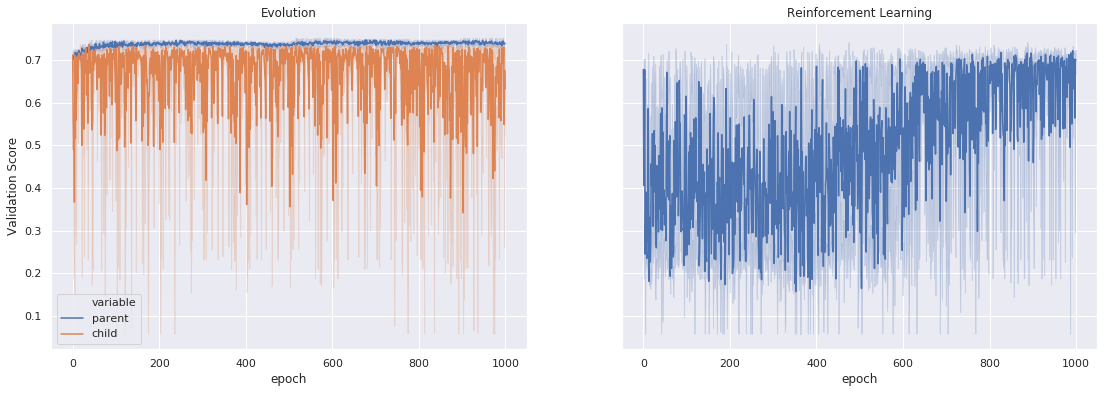

In [11]:
draw_lineplots('citeseer', ev_results_all, rl_results_all, all_seeds=True, macro=True)

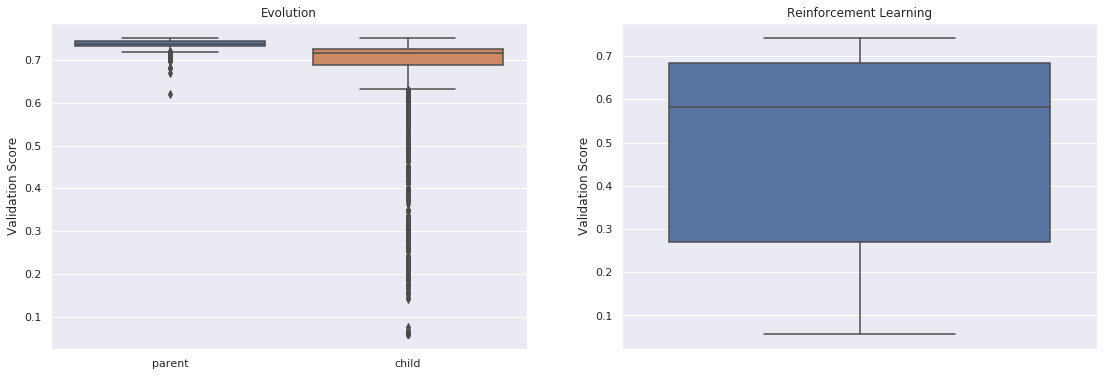

In [12]:
draw_boxplots('citeseer', ev_results_all, rl_results_all, all_seeds=True)

10 Time elapsed initializing population: 679.5973744392395
Time spent on evolution: 6420.884535551071
Total elapsed time: 7100.481909990311

123 Time elapsed initializing population: 690.2006266117096
Time spent on evolution: 7432.398113489151
Total elapsed time: 8122.598740100861

42 Time elapsed initializing population: 600.3560860157013
Time spent on evolution: 10441.695751428604
Total elapsed time: 11042.051837444305



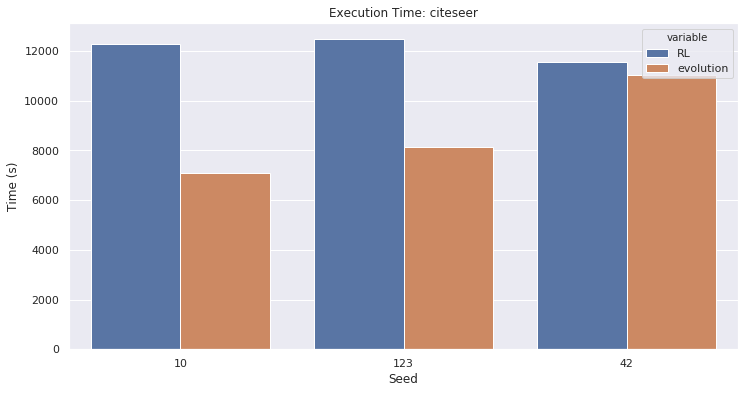

In [13]:
draw_barplot_time_across_seeds('citeseer', rl_times_all, ev_times_all, macro=True)

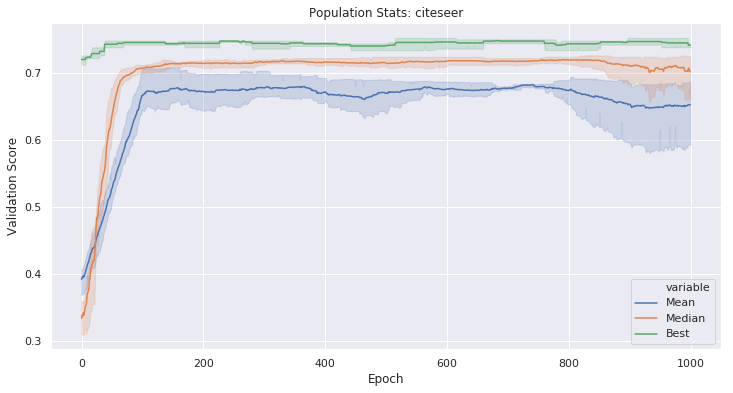

In [14]:
draw_population_stats_chart('citeseer', pop_stats_all, macro=True)

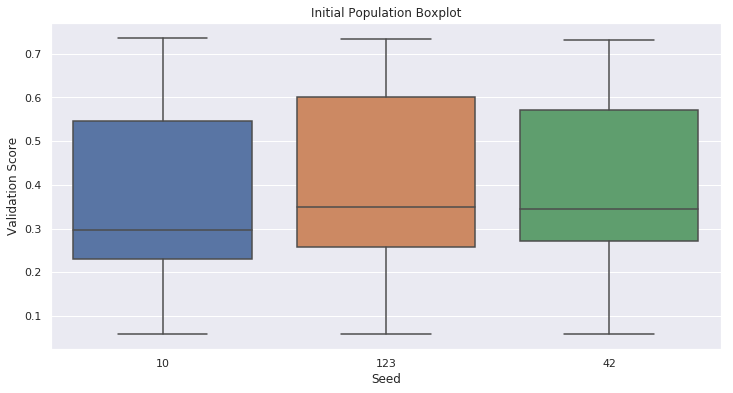

In [15]:
draw_initial_pop_boxplot('citeseer', initial_pop_all, macro=True)

### Cora

In [16]:
ev_results_all, initial_pop_all, ev_times_all, rl_results_all, rl_times_all, pop_stats_all = load_all_results('cora', macro=True)

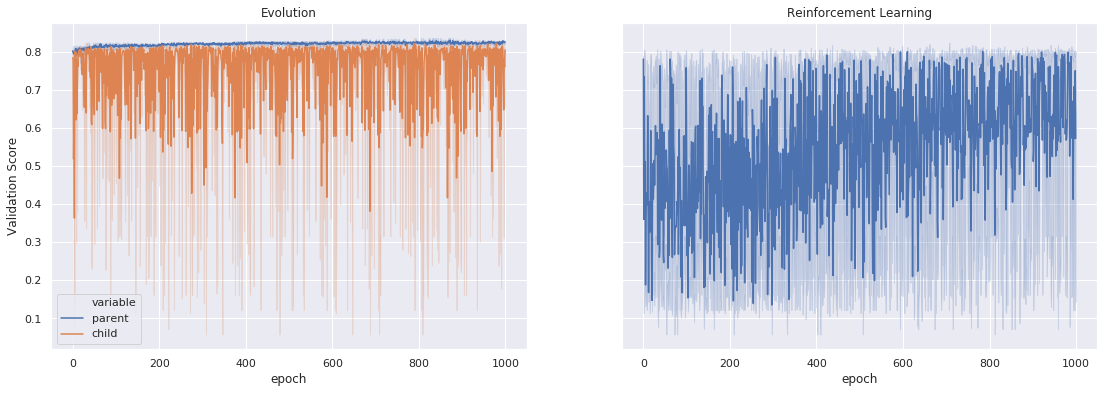

In [17]:
draw_lineplots('cora', ev_results_all, rl_results_all, all_seeds=True, macro=True)

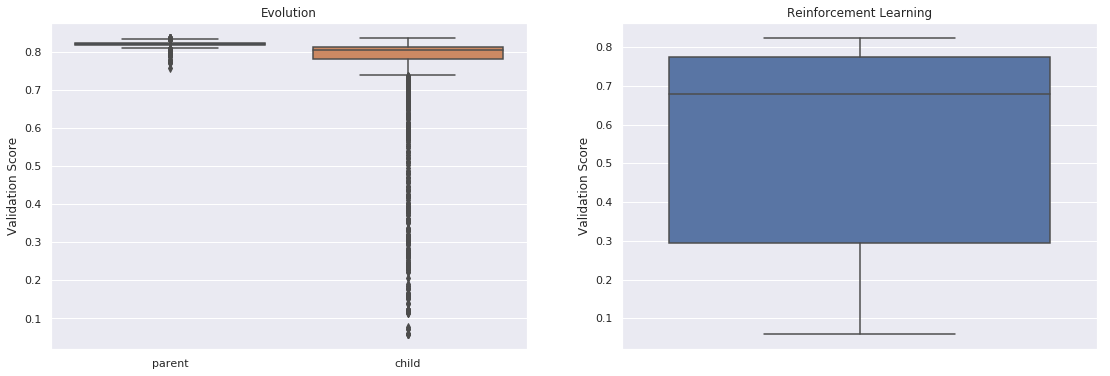

In [18]:
draw_boxplots('cora', ev_results_all, rl_results_all, all_seeds=True, macro=True)

10 Time elapsed initializing population: 646.2697350978851
Time spent on evolution: 4723.302840232849
Total elapsed time: 5369.572575330734

123 Time elapsed initializing population: 797.4401271343231
Time spent on evolution: 8906.804016828537
Total elapsed time: 9704.24414396286

42 Time elapsed initializing population: 1001.8271868228912
Time spent on evolution: 6438.141123056412
Total elapsed time: 7439.968309879303



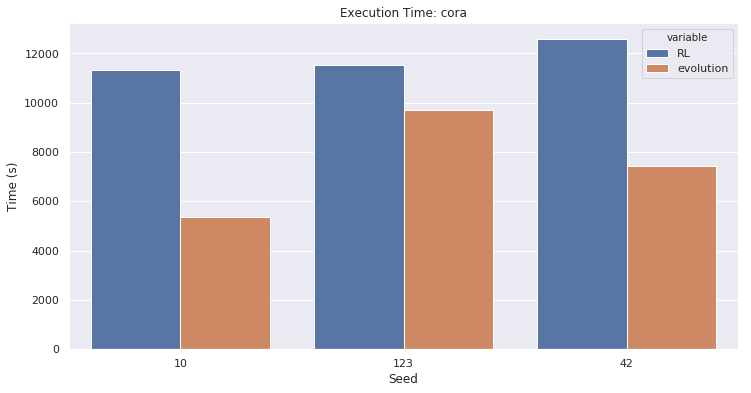

In [19]:
draw_barplot_time_across_seeds('cora', rl_times_all, ev_times_all, macro=True)

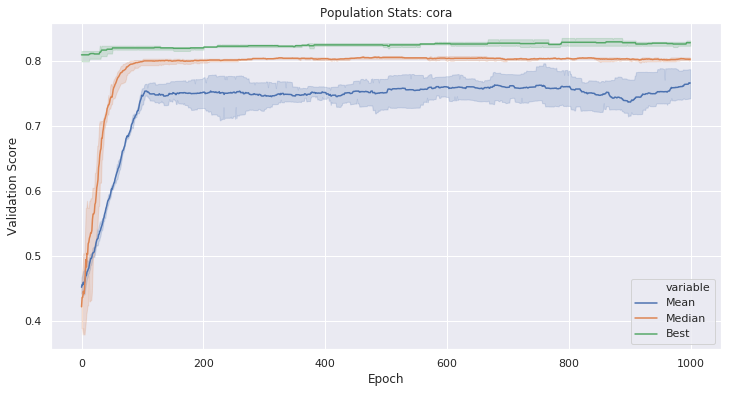

In [20]:
draw_population_stats_chart('cora', pop_stats_all, macro=True)

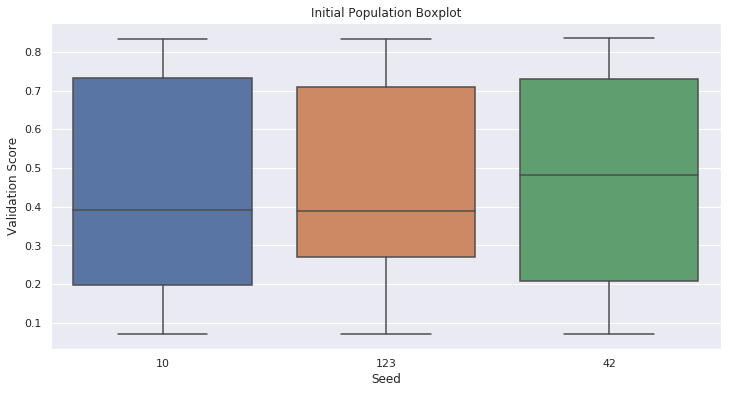

In [21]:
draw_initial_pop_boxplot('cora', initial_pop_all, macro=True)

### Pubmed

In [22]:
ev_results_all, initial_pop_all, ev_times_all, rl_results_all, rl_times_all, pop_stats_all = load_all_results('pubmed', macro=True)

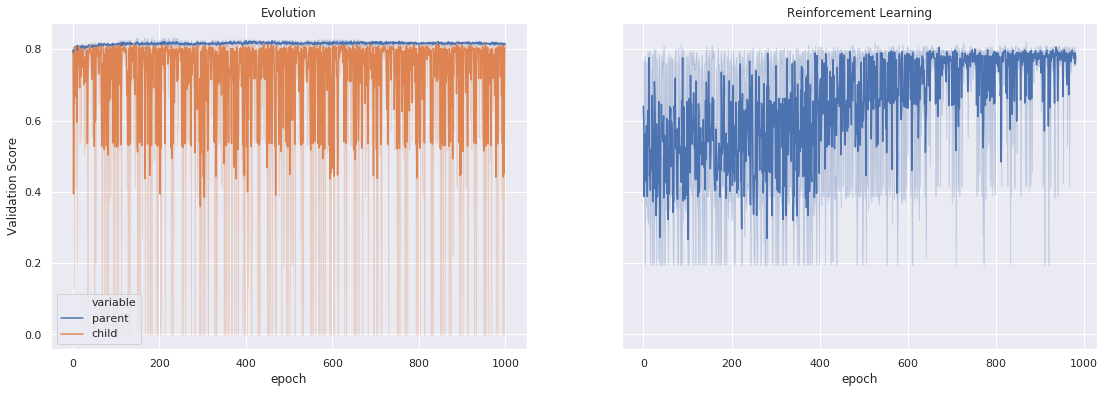

In [23]:
draw_lineplots('pubmed', ev_results_all, rl_results_all, all_seeds=True, macro=True)

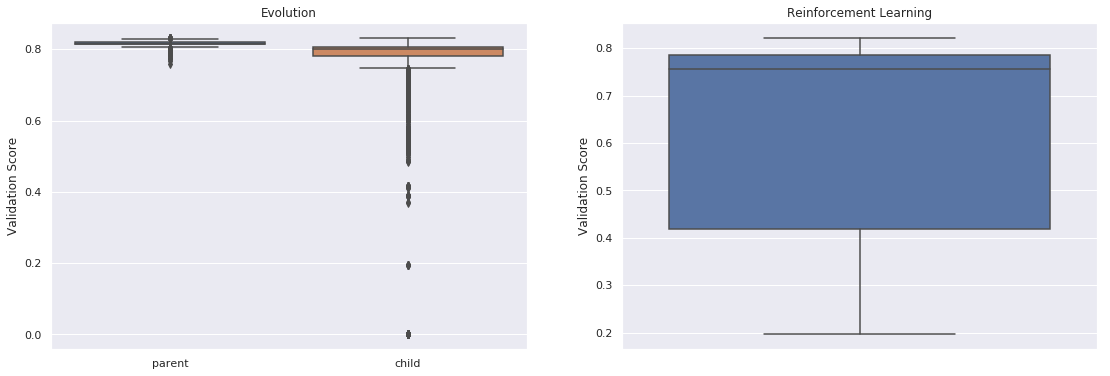

In [24]:
draw_boxplots('pubmed', ev_results_all, rl_results_all, all_seeds=True, macro=True)

10 Time elapsed initializing population: 1317.5363099575043
Time spent on evolution: 13281.30207657814
Total elapsed time: 14598.838386535645

123 Time elapsed initializing population: 1313.0753231048584
Time spent on evolution: 8520.679510354996
Total elapsed time: 9833.754833459854

42 Time elapsed initializing population: 1236.4904437065125
Time spent on evolution: 25004.25574016571
Total elapsed time: 26240.746183872223



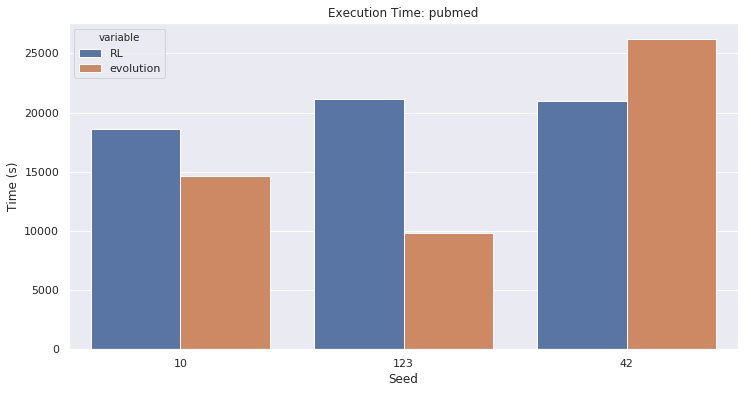

In [25]:
draw_barplot_time_across_seeds('pubmed', rl_times_all, ev_times_all, macro=True)

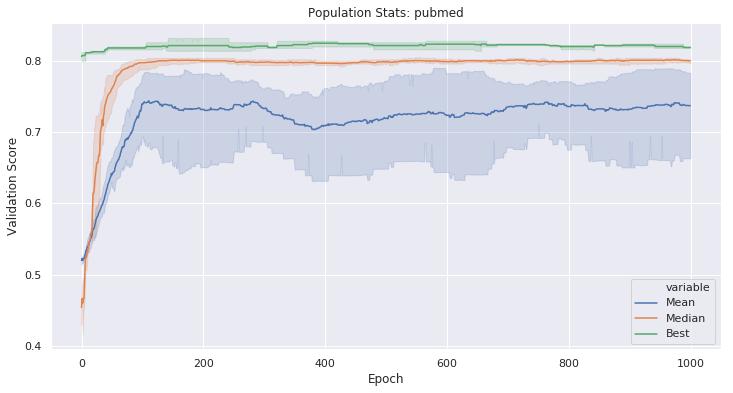

In [26]:
draw_population_stats_chart('pubmed', pop_stats_all, macro=True)

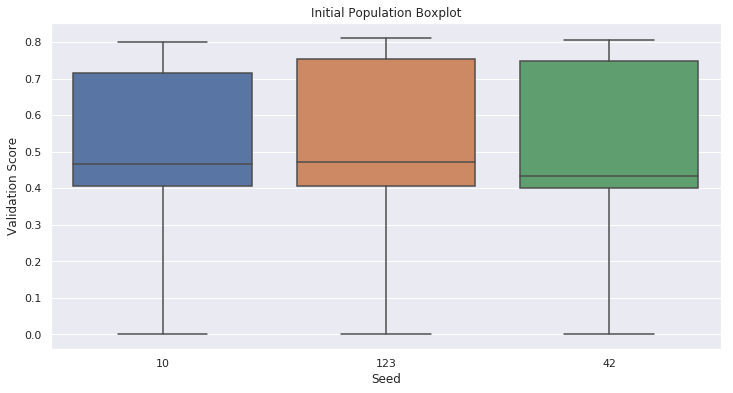

In [27]:
draw_initial_pop_boxplot('pubmed', initial_pop_all, macro=True)

# Micro Search Space

## Citeseer

In [28]:
ev_results_all, initial_pop_all, ev_times_all, rl_results_all, rl_times_all, pop_stats_all = load_all_results('citeseer', macro=False)

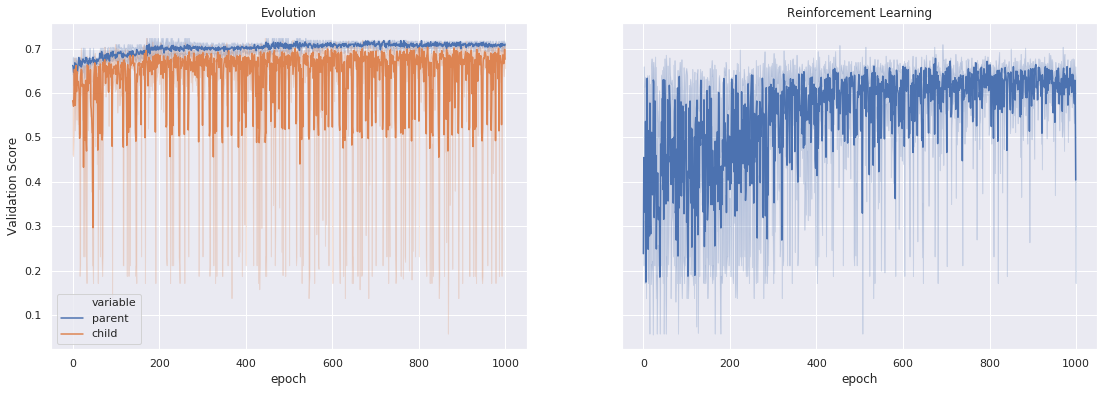

In [29]:
draw_lineplots('citeseer', ev_results_all, rl_results_all, all_seeds=True, macro=False)

10 Time elapsed initializing population: 1229.1564373970032
Time spent on evolution: 10786.371485948563
Total elapsed time: 12015.527923345566

123 Time elapsed initializing population: 1208.153788805008
Time spent on evolution: 12995.004791736603
Total elapsed time: 14203.15858054161

42 Time elapsed initializing population: 773.6074318885803
Time spent on evolution: 12391.606880426407
Total elapsed time: 13165.214312314987



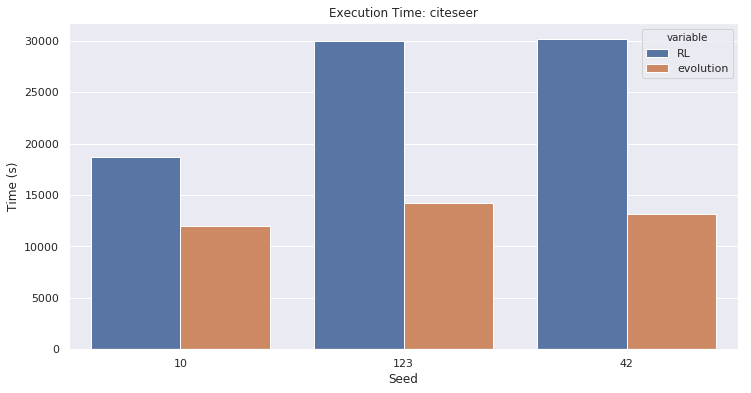

In [30]:
draw_barplot_time_across_seeds('citeseer', rl_times_all, ev_times_all, macro=False)

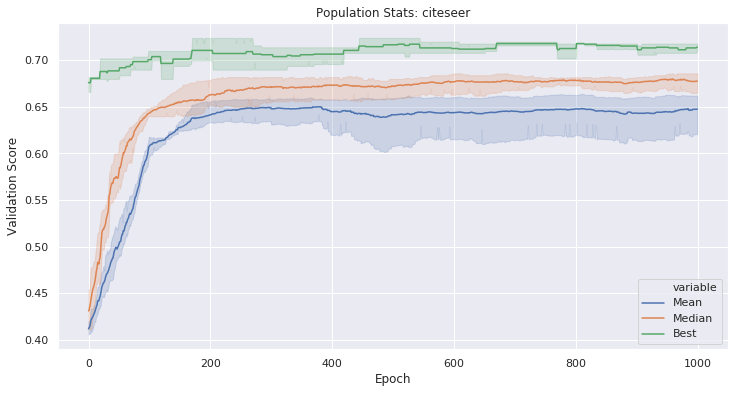

In [31]:
draw_population_stats_chart('citeseer', pop_stats_all, macro=False)

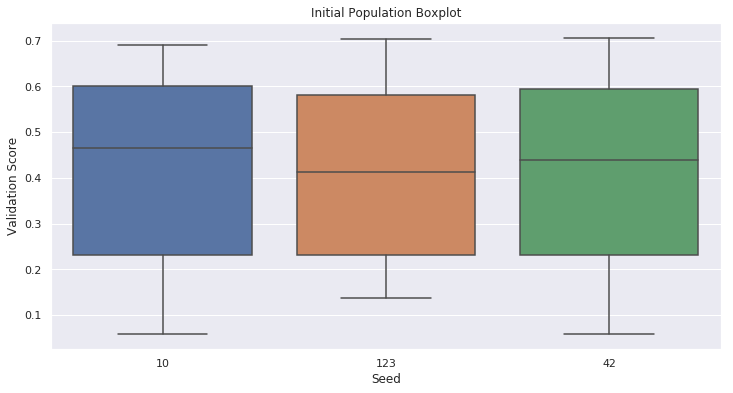

In [32]:
draw_initial_pop_boxplot('citeseer', initial_pop_all, macro=False)

## Cora

In [33]:
ev_results_all, initial_pop_all, ev_times_all, rl_results_all, rl_times_all, pop_stats_all = load_all_results('cora', macro=False)

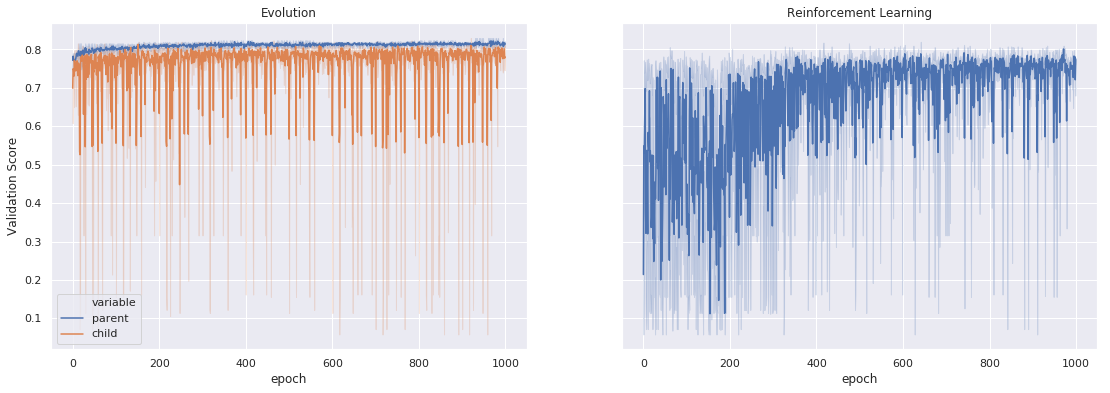

In [34]:
draw_lineplots('cora', ev_results_all, rl_results_all, all_seeds=True, macro=False)

10 Time elapsed initializing population: 1257.8930795192719
Time spent on evolution: 14496.378468751907
Total elapsed time: 15754.27154827118

123 Time elapsed initializing population: 1082.2102890014648
Time spent on evolution: 13619.64772105217
Total elapsed time: 14701.858010053635

42 Time elapsed initializing population: 1218.8942227363586
Time spent on evolution: 14760.476219415665
Total elapsed time: 15979.370442152023



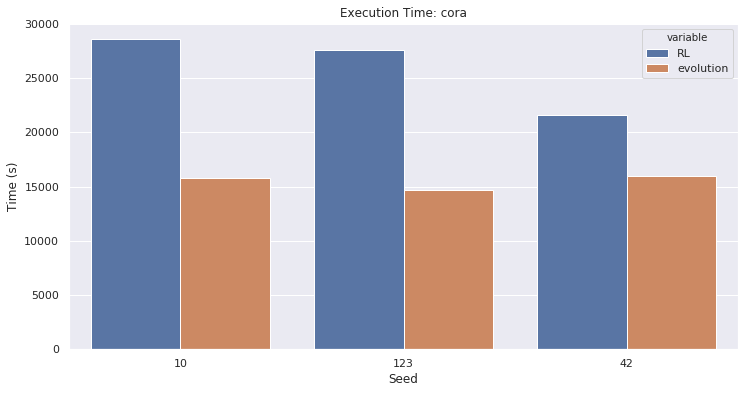

In [35]:
draw_barplot_time_across_seeds('cora', rl_times_all, ev_times_all, macro=False)

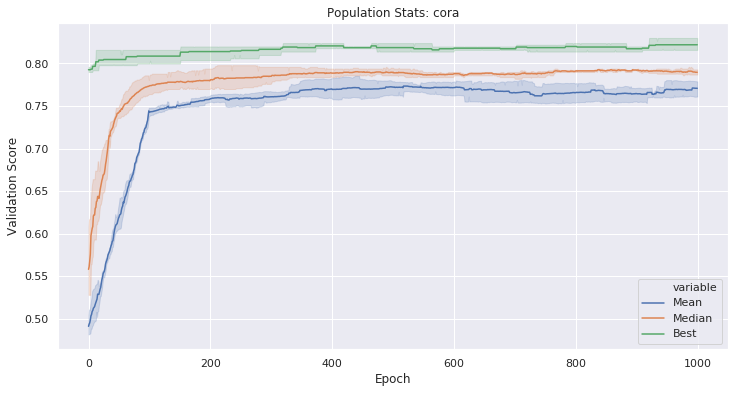

In [36]:
draw_population_stats_chart('cora', pop_stats_all, macro=False)

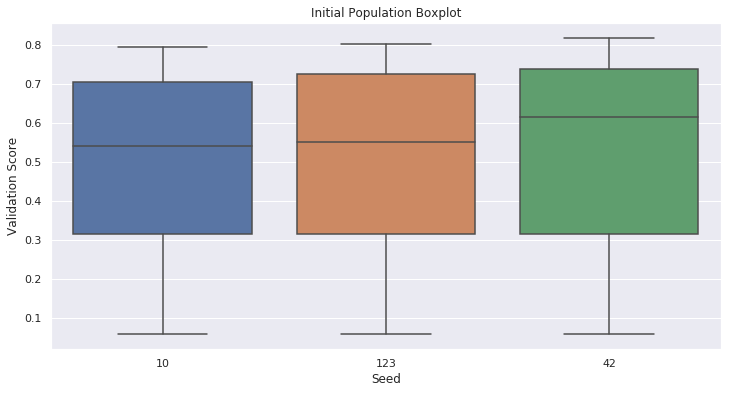

In [37]:
draw_initial_pop_boxplot('cora', initial_pop_all, macro=False)

## Pubmed

In [38]:
ev_results_all, initial_pop_all, ev_times_all, rl_results_all, rl_times_all, pop_stats_all = load_all_results('pubmed', macro=False)

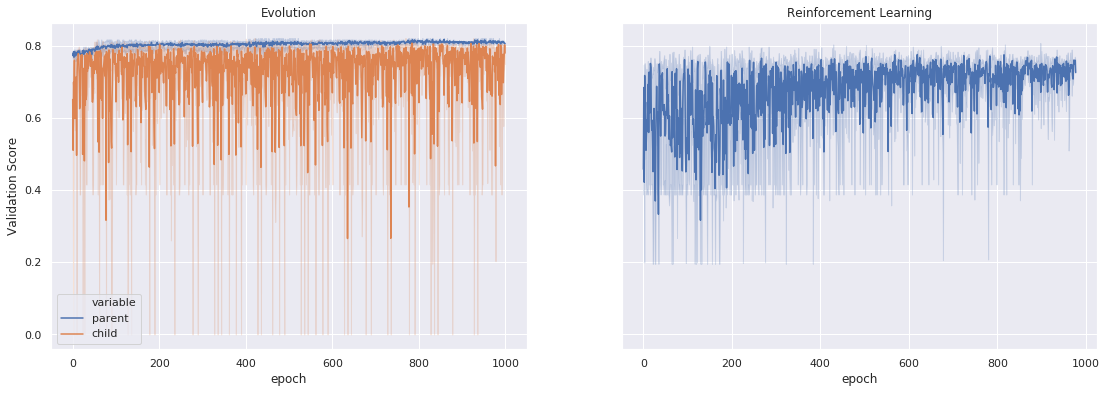

In [39]:
draw_lineplots('pubmed', ev_results_all, rl_results_all, all_seeds=True, macro=False)

10 Time elapsed initializing population: 1233.5862395763397
Time spent on evolution: 15883.94278049469
Total elapsed time: 17117.52902007103

123 Time elapsed initializing population: 1074.9586532115936
Time spent on evolution: 39075.627270936966
Total elapsed time: 40150.58592414856

42 Time elapsed initializing population: 1359.9827146530151
Time spent on evolution: 18301.206636190414
Total elapsed time: 19661.18935084343



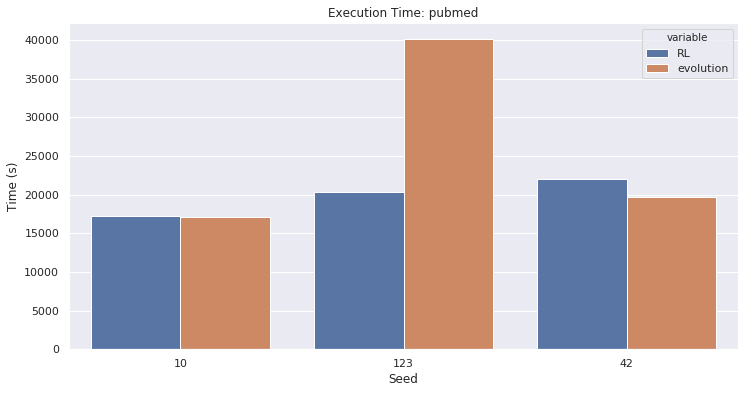

In [40]:
draw_barplot_time_across_seeds('pubmed', rl_times_all, ev_times_all, macro=False)

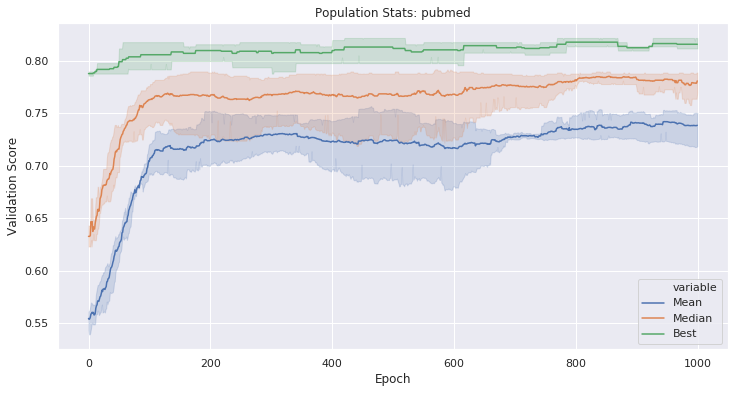

In [41]:
draw_population_stats_chart('pubmed', pop_stats_all, macro=False)

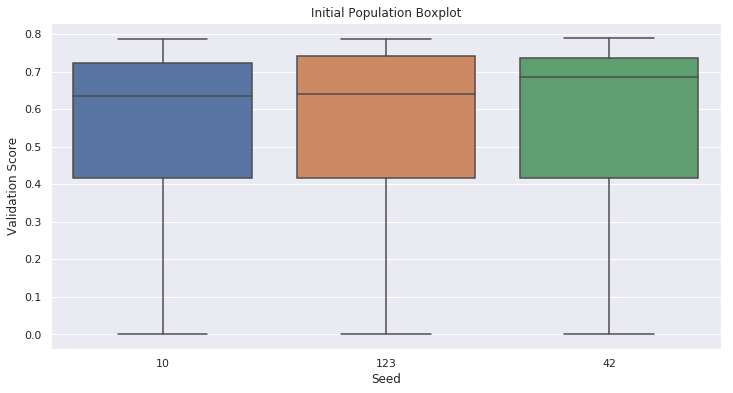

In [42]:
draw_initial_pop_boxplot('pubmed', initial_pop_all, macro=False)